# imports

In [1]:
import numpy as np
import warnings
from skimage import img_as_float, exposure
## used for mm-pix.tags
from collections import OrderedDict 
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
## is_background and autofocus
from skimage import color 
from skimage.util import view_as_windows, crop 
## autofocus
from skimage.filters import  sobel
from skimage.measure import shannon_entropy
## white balance
import scipy.interpolate
## background image
import tifffile as tf
## metadata
import difflib
import pprint

# import pycromanager

In [ ]:
from pycromanager import Core, Studio
from smartpath_libraries.sp_acquisition import SPAcquisition

def init_pycromanager():
    from pycromanager import Core, Studio
    core = Core()
    studio = Studio()
    core.set_timeout_ms(20000)
    return core, studio
core,studio = init_pycromanager()

# core functions

if core.is_sequence_running():
    studio.live().set_live_mode(False)
core.set_auto_shutter(True)

## yaml loader

In [4]:
import yaml
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config["user_config"], **config["model_config"], **config["hard_config"]}

## dataclasses

In [7]:



    
@dataclass
class sp_position:
    x: float
    y: float
    z: float = field(default=None)
    f: float = field(default=None)
    o: float = field(default=None)

    def __repr__(self):
        kws_values = [f"{key}={value:.1f}" for key, value in self.__dict__.items() if value]
        kws_none = [f"{key}={value!r}" for key, value in self.__dict__.items() if not value]
        kws = kws_values + kws_none
        return f"{type(self).__name__}({', '.join(kws)})"    


In [8]:
camm = sp_microscope_settings([0, 40000.0],[0, 30000.0])
position = sp_position(50,100,20.001)
camm, position

(sp_microscope_settings(x_range=[0, 40000.0], y_range=[0, 30000.0], z_range=None, f_range=None, focus_device='ZStage:Z:32'),
 sp_position(x=50.0, y=100.0, z=20.0, f=None, o=None))

In [165]:
#import json


In [ ]:
    pixel-size-bf-20x : 0.222 # 0.222 micron/pixel at (1392, 1040)
    pixel-size-bf-4x : 1.105 # 1.305 micron/pixel at (1392, 1040)
    pixel-size-shg-base : 0.509 # 0.509 micron/pixel at 256
    pixel-size-shg : 0.509
    camera-resolution : [1392, 1040] # (width, height)
    lsm-resolution-base : [512, 512]
    slide-size : [40000.0, 20000.0] # (width, height) (70000, -20000)
    Z-stage-20x : -6980 # -6930 + 290 / 10500
    Z-stage-laser : -6640 #-6640 
    Z-stage-4x : 3570 # -2300
    F-stage-20x : -15800 # 11000
    F-stage-laser : -18500 # -17500
    F-stage-4x : -1000
    Z-bf-offset : -10500
    Z-laser-offset : 290
    hard-limit-z : [-8500.0, 17000.0]
    hard-limit-x : [-5000.0, 40000.0]
    hard-limit-y : [-4200, 25000.0] #(-2200, 19000.0)
    hard-limit-f : [-19000, 0]
    20x-bf-offset : [-600, 10] # 4x + this value to 20x // (-590, 74)
    shg-offset : [-580, -280] # 4x + this value to shg // (-580, -172)
    led-4x : 4
    led-20x : 5
    focus-device : 'ZStage:Z:32'
    condensor-device : 'ZStage:F:32'
    led-device : ['LED-Dev1ao0', 'Voltage']
    obj-device : ['Turret:O:35', 'Label']

In [ ]:
core.get_devic

In [180]:

@dataclass
class sp_microscope_settings:
    x_range : list
    y_range : list
    z_stage : str
    z_range : list = field(default=None)
    f_stage : str
    f_range : list = field(default=None)
    obj_slider: str
    obj_values: list = field(default=None)

    
camm = sp_microscope_settings([0, 40000.0],[0, 30000.0], focus_device= 'ZStage:Z:32')
camm

TypeError: non-default argument 'focus_device' follows default argument

'ZStage:Z:32'

## smartpath

In [124]:

class smartpath:

    def __init__(self,core):
        self.core = core

        
    def get_mm_metadata_string(self, pretty_print=False):

        device_dict = self.get_device_properties(self.core)
        if pretty_print:
            return pprint.pformat(device_dict)
                    
        str = ''
        for device_name,prop_val in device_dict.items():
            for prop_name, values in prop_val.items():
                str = str + f'{device_name},{prop_name}: {values}' +'\n'
        return str
            
    @staticmethod
    def mm_object_to_list(name): return [name.get(i) for i in range(name.size())]

    @staticmethod
    def get_device_properties(core,scope='used'):
        """ 
        get used/allowed properties in mm2-device manager 
        as a dictionary
        """
        device_dict={}
        for device_name in smartpath.mm_object_to_list(core.get_loaded_devices()):            
            device_property_names = core.get_device_property_names(device_name)             
            property_names = smartpath.mm_object_to_list(device_property_names) 
            prop_dict ={}            
            for prop in property_names: 
                if scope=='allowed':
                    values = core.get_allowed_property_values(device_name, prop)  
                    prop_dict.update({f'{prop}': smartpath.mm_object_to_list(values)})
                elif scope =='used':
                    values = core.get_property(device_name, prop) 
                    prop_dict.update({f'{prop}': values})
                else:
                    warnings.warn(f" unknown metadata scope {scope} ")
            device_dict.update({f'{device_name}':prop_dict})
        return device_dict    
       
    @staticmethod
    def _compare_dicts(d1, d2):
        """ 
        Adapted version from cpython unit-test
        https://stackoverflow.com/questions/12956957/print-diff-of-python-dictionaries
        https://github.com/python/cpython/blob/01fd68752e2d2d0a5f90ae8944ca35df0a5ddeaa/Lib/unittest/case.py#L1091
        """
        return ('\n' + '\n'.join(difflib.ndiff(
                       pprint.pformat(d1).splitlines(),
                       pprint.pformat(d2).splitlines())))
    @staticmethod
    def compare_device_properties(dp1,dp2):
        if len(dp1.keys() ^ dp2.keys())==0:
        keys = dp1.keys()
        for key in keys:
            if len(set(dp1[key].items()) ^ set(dp2[key].items())):
                #difflib.context_diff()
                x= smartpath._compare_dicts(dp1[key],dp2[key])      
    
        for ix,k in enumerate(x.splitlines()):
            if k.startswith('?'):
                #print(x[ix-2:ix+1])
                print(x.splitlines()[ix-1])
                print(k)

    @staticmethod
    def is_coordinate_in_range(settings, position) -> bool:
        
        _within_ylimit = _within_xlimit = False
        if settings.x_range[0] < position.x < settings.x_range[1]:
            _within_xlimit = True
        else:
            warnings.warn(f" {position.x} out of range X {settings.x_range}")
        if settings.y_range[0] < position.y < settings.y_range[1]:
            _within_ylimit = True
        else:
            warnings.warn(f" {position.y} out of range Y {settings.y_range}")

        if not position.z:
            return _within_xlimit and _within_ylimit
        if settings.z_range:      
            _within_zlimit = False    
            if settings.z_range[0] < position.z < settings.z_range[1]:
                _within_zlimit = True
            else:
                warnings.warn(f" {position.z} out of range Y {settings.z_range}")            
            return _within_xlimit and _within_ylimit and _within_zlimit
        else:
            warnings.warn(f" Z range undefined : {settings.z_range}") 
            return False

            
    @staticmethod
    def get_current_position(core):
        current_pos = sp_position(core.get_x_position(), core.get_y_position(), core.get_position())
        return current_pos


    @staticmethod
    def move_to_position(position:sp_position,settings:sp_microscope_settings,core:Core):

        if position.f or position.o:
            warnings.warn(" F and O stage movements are not implemented yet")
            return 0
            
        if not position.x :
            position.x = smartpath.get_current_position(core).x
        if not position.y :
            position.y = smartpath.get_current_position(core).y
        if not position.z :
            position.z = smartpath.get_current_position(core).z
            
        # check position in range
        if smartpath.is_coordinate_in_range(settings,position):
            
            # verify focus device: bcs user can change it to F mode
            if core.get_focus_device() != settings.focus_device:
                warnings.warn(f" Changing focus device {core.get_focus_device()}")    
                core.set_focus_device(settings.focus_device)
                
            # movement
            core.set_position(position.z)
            core.set_xy_position(position.x, position.y)
            core.wait_for_device(core.get_xy_stage_device())
            core.wait_for_device(core.get_focus_device())
            
        else:
            print(" Movement Cancelled ")
            
    @staticmethod            
    def snap(core:Core() ,flip_channel=True, background_correction=False, remove_alpha=True):
        if core.is_sequence_running():
            studio.live().set_live_mode(False)
        core.snap_image()
        tagged_image = core.get_tagged_image()  
        tags = OrderedDict(sorted(tagged_image.tags.items()))
    
        ## QCAM
        if tags['Core-Camera'] == 'QCamera':
            pixels = np.reshape(
                tagged_image.pix,
                newshape=[tags['Height'], tags["Width"], 4],
                )
            
            if remove_alpha:
                pixels = pixels[:, :, 0:3]
            if flip_channel:
                pixels = np.flip(pixels, 2)
            if background_correction:
                pixels = smartpath.background_correction(pixels)
                
        ## OpenScan       
        elif tags['Core-Camera'] == 'OSc-LSM':
            pixels = np.reshape(
                tagged_image.pix,
                newshape=[tags['Height'], tags["Width"]],
                )
        else:
            print(f"Capture Failed: SP doesnt recognize : {tags['Core-Camera']=}")
            return None,tags
        
        return pixels,tags

    @staticmethod
    def autofocus ( core, 
                   settings:sp_microscope_settings,
                   nsteps = 5, 
                   search_range=45, 
                   interp_strength = 100, 
                   interp_kind ='quadratic' , 
                   score_metric = sobel, 
                   pop_a_plot = False,
                   move_stage_to_estimate=True):
        """
        score metric options : shannon_entropy, sobel
        """
        
        steps   = np.linspace(0,search_range,nsteps)-(search_range/2)
        current_pos = smartpath.get_current_position(core)
        z_steps = current_pos.z+steps
    
        try:
            #print(current_pos)
        
            scores=[]
            for step_number in range(nsteps):    
                new_pos = sp_position(current_pos.x,current_pos.y,current_pos.z+steps[step_number])
                move_to_position(new_pos,settings,core)
                #print(smartpath.get_current_position(core))
                img,tags = smartpath.snap(core)
                img_gray = color.rgb2gray(img)
                score = score_metric(img_gray)
                if score.ndim==2:
                    score = np.mean(score)
                scores.append(score)
        
            ## interpolation
            interp_x = np.linspace(z_steps[0],z_steps[-1], nsteps*interp_strength)
            interp_y = scipy.interpolate.interp1d(z_steps, scores, kind=interp_kind)(interp_x)
            new_z    = interp_x[np.argmax(interp_y)]
        
            if pop_a_plot:
                plt.figure()
                plt.bar(z_steps,scores)
                plt.plot(interp_x,interp_y,'k')
                plt.plot(interp_x[np.argmax(interp_y)],interp_y.max(),'or')
                plt.xlabel('Z-axis')
                plt.title(f'X,Y = ({current_pos.x:.1f} , {current_pos.y:.1f})')
    
            if move_stage_to_estimate:
                new_pos = current_pos
                new_pos.z = new_z
                move_to_position(new_pos,settings,core)
                return(new_z)
                #core.set_position(new_z)
        except Exception as e:
            move_to_position(current_pos,settings,core)
            return e
            
        

    @staticmethod
    def white_balance(img=None, imgb=None, gain=1.0):
        
        white_balance_profiles ={'4x_binLi_Jul2021' : [0.927, 1.0, 0.947],
                                 '20x_binLi_May2022': [1.0, 0.989, 0.803],
                                 '20x_jenu_Mar2024': [0.918, 1.0 ,0.806]
                                        }
        if imgb:
            r,g,b = imgb.mean((0,1))
            r1,g1,b1 = (r,g,b)/ max(r,g,b)
        else:
            r1,g1,b1 = white_balance_profiles['20x_jenu_Mar2024']
            
        imgx = img.astype(np.float64)*gain/[r1,g1,b1]
        return np.clip(imgx,0,255).astype(np.uint8) 








In [125]:
sp = smartpath(core)
stx = sp.get_mm_metadata_string()
with open(r'C:\Users\lociuser\Codes\smart-wsi-scanner\test.txt' ,'w') as fid:
    print(stx, file=fid)

In [ ]:
#smartpath.autofocus

In [107]:
sp = smartpath(core)
#print(sp.print_mm_status())
sp.get_current_position(core)

sp_position(x=19523.6, y=14049.0, z=-10504.3, f=None, o=None)

In [344]:
camm, sp.get_current_position(core)

(sp_microscope_settings(x_range=[0, 40000.0], y_range=[0, 30000.0], z_range=[-10600, -10400], f_range=None, focus_device='ZStage:Z:32'),
 sp_position(x=19523.6, y=14049.0, z=-10527.0, f=None, o=None))

In [351]:
#smartpath.autofocus(core,camm,pop_a_plot=True,search_range=60)

In [104]:
%%time
dp = sp.get_device_properties(core)

CPU times: total: 188 ms
Wall time: 222 ms


In [105]:
%%time
dp = sp.get_device_properties(core,'allowed')

CPU times: total: 250 ms
Wall time: 441 ms


In [108]:
%%time
sp = smartpath(core)
stx = sp.get_mm_metadata_string()
#print(stx)

CPU times: total: 203 ms
Wall time: 413 ms


## Bins utils

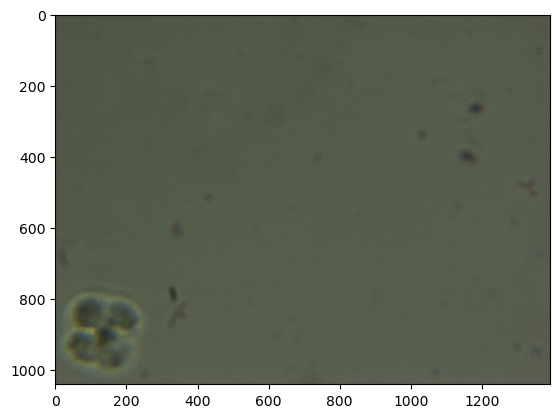

In [369]:
#imgb,tags = smartpath.snap(core)
plt.imshow(imgb)

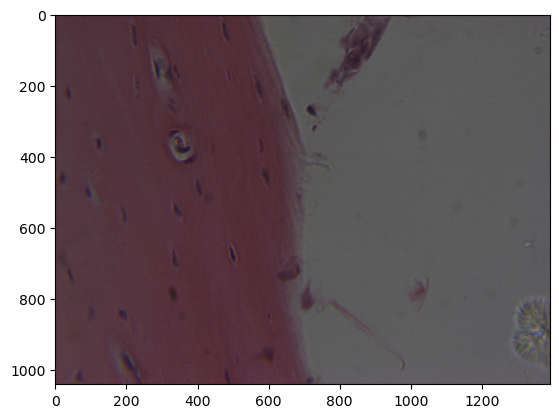

In [377]:
plt.imshow(smartpath.white_balance(img))

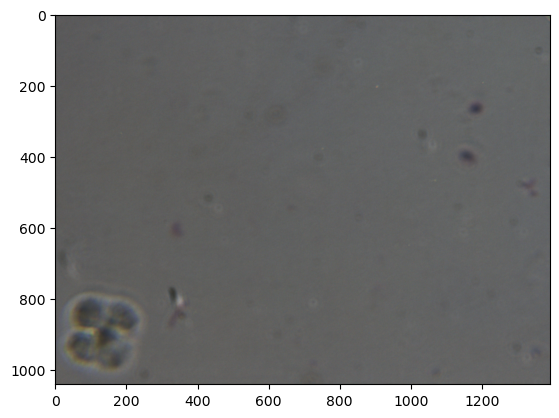

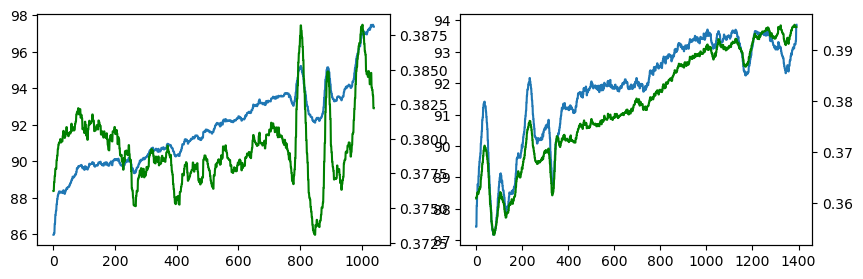

In [392]:
imga = smartpath.white_balance(imgb)
imga1 = binli_utils.flat_field(imga,bg_20x)
plt.imshow(imga1)
plt.figure(figsize=[10,3])
ax1= plt.subplot(121)
ax1.plot(imga.mean((1,2)))
ax2 = ax1.twinx()
ax2.plot(imga1.mean((1,2)),'g')
#figure()
ax1= plt.subplot(122)
ax1.plot(imga.mean((0,2)))
ax2 = ax1.twinx()
ax2.plot(imga1.mean((0,2)),'g')

In [373]:
#binli_utils.is_background(imgb,0.28,0.28)

### is background

In [398]:

def is_background2(img, thr_saturation=0.3, thr_brightness=0.32):
    # TODO : ?
    patch_h = int(img.shape[0]/8)
    patch_w = int(img.shape[1]/8)
    img = color.rgb2hsv(img)
    img_windows = np.squeeze(view_as_windows(img, (patch_h, patch_w, 3), step=(patch_h, patch_w, 3)))
    img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], patch_h, patch_w, 3)) # nxm, 256, 256, 3
    img_max = np.max(img_windows, axis=0) # 256x256x3
    img_min = np.min(img_windows, axis=0) # 256x256x3
    sat_img = img_max[:, :, 1]
    bright_img = 1-img_min[:, :, 2]
    ave_sat = np.sum(sat_img)/(patch_h*patch_w)
    ave_bright = np.sum(bright_img)/(patch_h*patch_w)
    return ave_sat < t and ave_bright < tt

((8, 8, 1, 129, 173, 3), (1040, 1392, 3), 4284864, 4343040)

In [400]:
k.shape, img.shape, k.size, img.size

((8, 8, 1, 130, 174, 3), (1040, 1392, 3), 4343040, 4343040)

In [402]:
k.shape

(8, 8, 1, 130, 174, 3)

In [401]:
k2.shape

(64, 130, 174, 3)

130 174


(0.4702418320838873, 0.769309131256393)

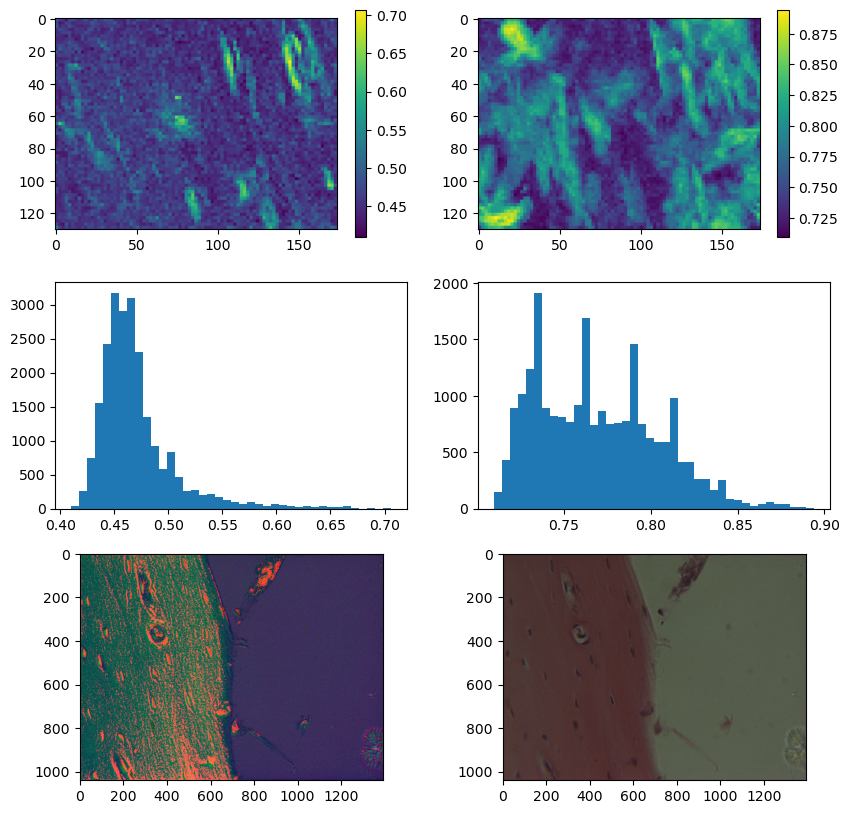

In [445]:
img_hsv = color.rgb2hsv(img)
patch_h = int(img_hsv.shape[0]/8)#-1
patch_w = int(img_hsv.shape[1]/8)#-1
print(patch_h,patch_w)
k  = view_as_windows(img_hsv, (patch_h, patch_w, 3), step=(patch_h, patch_w, 3))
k2 = np.reshape(k, (k.shape[0]*k.shape[1], patch_h, patch_w, 3)) 
k3 = np.max(k2, axis=0)
k4 = np.min(k2, axis=0)
s_img = k3[:,:,1]
b_img = 1-k4[:,:,2]

plt.figure(figsize =[10,10])
plt.subplot(321)
plt.imshow(s_img)
plt.colorbar()
plt.subplot(322)
plt.imshow(b_img)
plt.colorbar()
plt.subplot(323)
plt.hist(s_img.ravel(),40)
#plt.colorbar()
plt.subplot(324)
plt.hist(b_img.ravel(),40)
#plt.colorbar()
#plt.figure()
plt.subplot(3,2,5)
plt.imshow(img_hsv)
plt.subplot(3,2,6)
plt.imshow(color.hsv2rgb(img_hsv))

s_img.mean((0,1)), b_img.mean((0,1))

## flat field, set_mode and set_obj

In [140]:


class binli_utils:

    def __init__(self):
        pass

    @staticmethod
    def flat_field(img, bg, gain=1):
         # TODO : ?
        img = img_as_float(img)
        bg = img_as_float(bg)
        r = np.mean(bg[:, :, 0])
        g = np.mean(bg[:, :, 1])
        b = np.mean(bg[:, :, 2])
        img[:, :, 0] = 1 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 0], bg[:, :, 0] + 0.00) * r * gain, 0, 1), in_range=(0, 0.95), out_range=(0, 1))
        img[:, :, 1] = 1 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 1], bg[:, :, 1] + 0.00) * g * gain, 0, 1), in_range=(0, 0.95), out_range=(0, 1))
        img[:, :, 2] = 1 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 2], bg[:, :, 2] + 0.00) * b * gain, 0, 1), in_range=(0, 0.95), out_range=(0, 1))
        return img

    @staticmethod
    def is_background(img, t=0.3, tt=0.32):
        # TODO : ?
        patch_h = int(img.shape[0]/8)
        patch_w = int(img.shape[1]/8)
        img = color.rgb2hsv(img)
        img_windows = np.squeeze(view_as_windows(img, (patch_h, patch_w, 3), step=(patch_h, patch_w, 3)))
        img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], patch_h, patch_w, 3)) # nxm, 256, 256, 3
        img_max = np.max(img_windows, axis=0) # 256x256x3
        img_min = np.min(img_windows, axis=0) # 256x256x3
        sat_img = img_max[:, :, 1]
        bright_img = 1-img_min[:, :, 2]
        ave_sat = np.sum(sat_img)/(patch_h*patch_w)
        ave_bright = np.sum(bright_img)/(patch_h*patch_w)
        return ave_sat < t and ave_bright < tt

    @staticmethod
    def estimate_background(config, save_path, acq_name, position_list=None, mda=True):
        # TODO : ? check callstack ## never used?
        sum_img = np.zeros((config["camera-resolution"][0], config["camera-resolution"][1], 3))
        sum_count = 0
        if mda:
            data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
            dataset = Dataset(data_path)
        else:
            image_list = glob.glob(os.path.join(glob.glob(save_path+'/'+acq_name+'*')[-1], '*.tiff'))
        bg_stack = []
        for pos_row in range(position_list.shape[0]):
            for pos_col in range(position_list.shape[1]):
                if mda:
                    img = dataset.read_image(position=pos_row*position_list.shape[1]+pos_col)
                else:
                    img = io.imread(image_list[pos_row*position_list.shape[1]+pos_col])
                if is_background(img):
                    bg_stack.append(img)
                    sum_count = sum_count + 1
        bg_stack= np.stack(bg_stack)
        median = np.median(bg_stack, axis=0)
        median = img_as_float(median)
        return median



In [ ]:
sp_microscope_settings

In [167]:
config

{'exposure-level': 'high',
 'snr-level': 'low',
 'autofocus-speed': 3,
 'lsm-resolution': 256,
 'lsm-bin-factor': 15,
 'lsm-scan-rate': '250000.0000',
 'lsm-pc-power': 0.4,
 'lsm-pmt-gain': 0.4,
 'slide-box': [-100, 600, 25500.0, 17000.0],
 'lsm-enhancer': None,
 'bf-enhancer': None,
 'classifier': None,
 'adv-interval': 3,
 'average-factor': 50,
 'batch-size': 8,
 'blindspot-rate': 0.05,
 'cnn-base-channel': 8,
 'dataset': 'datasets/PA_2081b',
 'gan-lambda': 5,
 'gpu': True,
 'image-channel': 1,
 'image-extension': 'tif',
 'iter-per-epoch': 200,
 'iterations': 200000,
 'learning-rate': 0.0001,
 'load-weights': 'supervised2022-08-07_13-02-52',
 'loss-gain': 1000,
 'norm-range': [5420, 44017],
 'norm-range-target': [6265, 38567],
 'only-pixel-loss': False,
 'percep-lambda': 0.5,
 'resolution': 512,
 'test-interval': 5,
 'threads': 0,
 'up-scale-factor': 2,
 'pixel-size-bf-20x': 0.222,
 'pixel-size-bf-4x': 1.105,
 'pixel-size-shg-base': 0.509,
 'pixel-size-shg': 0.509,
 'camera-resolutio

In [174]:
sp.mm_object_to_list(core.get_available_pixel_size_configs())

['20x', '4x']

In [175]:
sp.mm_object_to_list(core.get_available_property_blocks())

[]

In [176]:
core.set_config('ColorON','ON')

In [173]:
for group_name in sp.mm_object_to_list(core.get_available_config_groups()):
    print(group_name)
    print(sp.mm_object_to_list(core.get_available_configs(group_name)))
#core.get_available_configs()


ColorON
['OFF', 'ON']
Imaging
['Camera', 'LSM']
LSM-Camera Switch
['OSc-LSM', 'QCamera']
PMT Gain
['NewPreset']
PMT HV ON
['Off', 'On']
PixelRate
['100000.0000', '1000000.0000', '125000.0000', '1250000.0000', '200000.0000', '250000.0000', '400000.0000', '50000.0000', '500000.0000', '625000.0000']
Pixels
['1024', '2048', '256', '512']
PockelCell
['NewPreset']
Scantype
['4xBF']
System
['Startup']
WhiteLEDBrightness
['NewPreset']
Zoom
['NewPreset']


In [ ]:


def change_mode_of_imaging(mode = '4xbf'):
    """
    CAMM 
    select modes : 4xbf   20xbf  20xshg
    """
    if mode =='4xbf':
        
    



In [ ]:
    def switch_objective(self, mag='4x'):
        config = self.config
        core = self.core
        if mag == '4x':
            core.set_property('Turret:O:35', 'Label', 'Position-2')
            core.set_focus_device(config['condensor-device'])
            core.set_position(config['F-stage-4x'])
            core.set_focus_device(config['focus-device'])
            focus_z = limit_stage(config['Z-stage-4x'], (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-4x'])
            core.set_position(focus_z)
            core.set_property(config['led-device'][0], config['led-device'][1], config['led-4x'])
            core.wait_for_system()
            print("Imaging objective set as 4x")
        if mag == '20x':
            core.set_property(config['obj-device'][0], config['obj-device'][1], 'Position-1')
            core.set_focus_device(config['condensor-device'])
            core.set_position(config['F-stage-20x'])
            core.set_focus_device(config['focus-device'])
            focus_z = limit_stage(config['Z-stage-20x'], (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-20x'])
            core.set_position(focus_z)
            core.set_property(config['led-device'][0], config['led-device'][1], config['led-20x'])
            core.wait_for_system()
            print("Imaging objective set as 20x")
            
            
    def switch_mod(self, mod='shg'):
        core = self.core
        config = self.config
        current_objective = core.get_property('Turret:O:35', 'Label')
        core.set_auto_shutter(True)
        if mod == 'shg':
            if current_objective == 'Position-2':
                print('Current magnification not supported for LSM. Switching magnification.')
                core.set_property(config['obj-device'][0], config['obj-device'][1], 'Position-1')
                core.wait_for_system()
            core.set_property('Turret:O:35', 'Label', 'Position-1')
            core.set_focus_device(config['condensor-device'])
            core.set_position(config['F-stage-laser']) # new value
            core.set_focus_device(config['focus-device'])
            focus_z = limit_stage(config['Z-stage-laser'], (config['hard-limit-z'][0], config['hard-limit-z'][1]), default=config['Z-stage-laser'])
            core.set_position(focus_z) #
            core.set_config('Imaging', 'LSM')
            core.set_property(config['led-device'][0], config['led-device'][1], 0.0)
            core.set_property('Shutters-DigitalIODev1', 'State', 3)
            core.set_property('Core', 'Camera', 'OSc-LSM')
            core.set_property('Core', 'Shutter', 'UniblitzShutter')
            core.set_property('QCamera', 'Color', 'OFF')
            core.set_property('OSc-LSM', 'LSM-Resolution', str(int(config['lsm-resolution'])))
            core.set_property('OSc-LSM', 'LSM-PixelRateHz', config['lsm-scan-rate'])
            core.set_property('PockelsCell-Dev1ao1', 'Voltage', config['lsm-pc-power'])
            core.set_property("DCCModule1","EnableOutputs","On")
            core.set_property("DCCModule1","ClearOverloads","Clear")            
            core.wait_for_system()
            core.set_property("DCCModule1","EnableOutputs","On")
            core.set_property("DCCModule1","C1_GainHV",config['lsm-pmt-gain']*100)
            core.wait_for_system()
            print("Imaging mode set as SHG")

        if mod == 'bf':
            core.set_property("DCCModule1","EnableOutputs","Off")
            core.wait_for_system()
            core.set_config('Imaging', 'Camera')
            core.set_property('Shutters-DigitalIODev1', 'State', 0)
            core.set_property('Core', 'Camera', 'QCamera')
            core.set_property('Core', 'Shutter', 'WhiteLED')
            core.set_property('QCamera', 'Color', 'ON')
            if current_objective == 'Position-2':
                self.switch_objective('4x')
            if current_objective == 'Position-1': 
                self.switch_objective('20x')  
            print("Imaging mode set as Brightfield")

In [ ]:



sp = smartpath(core)
mm_metadata = sp.print_mm_status()

mm_metadata

In [181]:
core.get_property('Turret:O:35','Label')

'Position-1'

In [ ]:

dp1 = sp.get_device_properties(core)
core.set_property('QCamera', 'Color', 'OFF')
dp2 = sp.get_device_properties(core)

In [152]:
'Turret:O:35'

-  'Color': 'ON',
?             ^
+  'Color': 'OFF',
?             ^^


In [158]:
#pprint.pprint(dp1)

In [166]:
#print(pprint.pformat(dp1))#.splitlines()

## check f-stage

In [ ]:
sp = smartpath(core)
mm_metadata = sp.print_mm_status()

mm_metadata

In [33]:
smartpath.mm_object_to_list(core.get_available_config_groups())

['ColorON',
 'Imaging',
 'LSM-Camera Switch',
 'PMT Gain',
 'PMT HV ON',
 'PixelRate',
 'Pixels',
 'PockelCell',
 'Scantype',
 'System',
 'WhiteLEDBrightness',
 'Zoom']

In [25]:
studio.has_config_changed()

False

In [ ]:
core.create_tagged_image

In [39]:
mm_all_device_adapter = smartpath.mm_object_to_list(core.get_device_adapter_names())
len(mm_all_device_adapter), mm_all_device_adapter[:10]

(228,
 ['89North_LDI',
  'AAAOTF',
  'ABSCamera',
  'AgilentLaserCombiner',
  'Aladdin',
  'AmScope',
  'Andor',
  'AndorDragonfly',
  'AndorILE',
  'AndorLaserCombiner'])

In [41]:
core.get_focus_device()

'ZStage:Z:32'

In [ ]:
core.get_available_configs()

In [42]:
smartpath.mm_object_to_list(core.get_available_property_blocks())

[]

In [44]:
#smartpath.mm_object_to_list(core.get_available_configs())

In [46]:
#core.get_available_device_types()

In [ ]:
#core.get_allowed_property_values('Core-Camera')

In [51]:
smartpath.mm_object_to_list(core.get_allowed_property_values('Core','Camera')) 

['', 'OSc-LSM', 'QCamera']

In [50]:
smartpath.mm_object_to_list(core.get_allowed_property_values('Core','Focus'))

['', 'ZStage:F:32', 'ZStage:Z:32']

## performance queries

## configs and tags

In [216]:
for key in sorted(config.keys(), key = lambda x:x.split('-')[0]):
    print( f"{key:>20} || {config[key]} ")
    #break

       20x-bf-offset || [-600, 10] 
         F-stage-20x || -15800 
       F-stage-laser || -18500 
          F-stage-4x || -1000 
         Z-stage-20x || -6980 
       Z-stage-laser || -6640 
          Z-stage-4x || 3570 
         Z-bf-offset || -10560 
      Z-laser-offset || 290 
        adv-interval || 3 
     autofocus-speed || 3 
      average-factor || 50 
          batch-size || 8 
         bf-enhancer || None 
      blindspot-rate || 0.05 
   camera-resolution || [1392, 1040] 
          classifier || None 
    cnn-base-channel || 8 
    condensor-device || ZStage:F:32 
             dataset || datasets/PA_2081b 
      exposure-level || high 
        focus-device || ZStage:Z:32 
          gan-lambda || 5 
                 gpu || True 
        hard-limit-z || [-8500.0, 17000.0] 
        hard-limit-x || [-5000.0, 40000.0] 
        hard-limit-y || [-4200, 25000.0] 
        hard-limit-f || [-19000, 0] 
       image-channel || 1 
     image-extension || tif 
      iter-per-epoch || 2

In [12]:
smartpath.mm_object_to_list(core.get_loaded_devices())

['COM3',
 'OScHub',
 'OSc-LSM',
 'OSc-Magnifier',
 'DCCHub',
 'DCCModule1',
 'NIMultiAnalogDev1',
 'LED-Dev1ao0',
 'PockelsCell-Dev1ao1',
 'Shutters-DigitalIODev1',
 'UniblitzShutter',
 'QCamera',
 'TigerCommHub',
 'XYStage:XY:31',
 'ZStage:Z:32',
 'ZStage:F:32',
 'Turret:O:35',
 'WhiteLED',
 'Core']

In [21]:
sp = smartpath(core)
mm_metadata = sp.print_mm_status()
print(mm_metadata)

COM3
	AnswerTimeout:500.0000
	BaudRate:115200
	DTR:Disable
	DataBits:8
	DelayBetweenCharsMs:0.0000
	Description:Serial port driver (boost:asio)
	Fast USB to Serial:Disable
	Handshaking:Off
	Name:COM3
	Parity:None
	StopBits:1
	Verbose:1
----------------------------
OScHub
----------------------------
OSc-LSM
	Binning:1
	Clock:OpenScan-NIDAQ@PXI1Slot2
	Detector:OpenScan-NIDAQ@PXI1Slot2
	Exposure:0.0000
	LSM-PixelRateHz:200000.0000
	LSM-Resolution:512
	LSM-ZoomFactor:1.0000
	PXI1Slot2-Acq Buffer Size (lines):8
	PXI1Slot2-EnableChannel0:Yes
	PXI1Slot2-EnableChannel1:No
	PXI1Slot2-EnableChannel2:No
	PXI1Slot2-EnableChannel3:No
	PXI1Slot2-EnableChannel4:No
	PXI1Slot2-EnableChannel5:No
	PXI1Slot2-EnableChannel6:No
	PXI1Slot2-EnableChannel7:No
	PXI1Slot2-GalvoOffsetX (degree):0.0000
	PXI1Slot2-GalvoOffsetY (degree):0.0000
	PXI1Slot2-Input Voltage Range:10.0000
	PXI1Slot2-Line Delay (pixels):50
	PXI1Slot2-Parking Position X (pixels):0
	PXI1Slot2-Parking Position Y (pixels):0
	PXI1Slot2-ScannerO

In [23]:
img, tags = smartpath.snap(core)

In [24]:
tags

OrderedDict([('Binning', '1'),
             ('BitDepth', 8),
             ('COM3-AnswerTimeout', '500.0000'),
             ('COM3-BaudRate', '115200'),
             ('COM3-DTR', 'Disable'),
             ('COM3-DataBits', '8'),
             ('COM3-DelayBetweenCharsMs', '0.0000'),
             ('COM3-Description', 'Serial port driver (boost:asio)'),
             ('COM3-Fast USB to Serial', 'Disable'),
             ('COM3-Handshaking', 'Off'),
             ('COM3-Name', 'COM3'),
             ('COM3-Parity', 'None'),
             ('COM3-StopBits', '1'),
             ('COM3-Verbose', '1'),
             ('CameraChannelIndex', 0),
             ('Channel', 'Default'),
             ('ChannelIndex', 0),
             ('Core-AutoFocus', ''),
             ('Core-AutoShutter', '1'),
             ('Core-Camera', 'QCamera'),
             ('Core-ChannelGroup', ''),
             ('Core-Focus', 'ZStage:Z:32'),
             ('Core-Galvo', ''),
             ('Core-ImageProcessor', ''),
             ('Core-

CPU times: total: 344 ms
Wall time: 473 ms


In [80]:
print(device_dict.keys())

dict_keys(['COM3', 'OScHub', 'OSc-LSM', 'OSc-Magnifier', 'DCCHub', 'DCCModule1', 'NIMultiAnalogDev1', 'LED-Dev1ao0', 'PockelsCell-Dev1ao1', 'Shutters-DigitalIODev1', 'UniblitzShutter', 'QCamera', 'TigerCommHub', 'XYStage:XY:31', 'ZStage:Z:32', 'ZStage:F:32', 'Turret:O:35', 'WhiteLED', 'Core'])


COM3,AnswerTimeout: []
COM3,BaudRate: ['1000000', '110', '115200', '1200', '128000', '14400', '19200', '2000000', '230400', '2400', '300', '38400', '460800', '4800', '500000', '57600', '600', '921600', '9600']
COM3,DTR: ['Disable', 'Enable']
COM3,DataBits: ['7', '8']
COM3,DelayBetweenCharsMs: []
COM3,Description: []
COM3,Fast USB to Serial: ['Disable', 'Enable']
COM3,Handshaking: ['Hardware', 'Off', 'Software']
COM3,Name: []
COM3,Parity: ['Even', 'None', 'Odd']
COM3,StopBits: ['1', '1.5', '2']
COM3,Verbose: ['0', '1']
OSc-LSM,Binning: ['1']
OSc-LSM,Clock: ['OpenScan-NIDAQ@Dev1', 'OpenScan-NIDAQ@PXI1Slot2', 'OpenScan-NIDAQ@PXI1Slot3', 'Unselected']
OSc-LSM,Detector: ['OpenScan-NIDAQ@Dev1', 'OpenScan-NIDAQ@PXI1Slot2', 'OpenScan-NIDAQ@PXI1Slot3', 'Unselected']
OSc-LSM,Exposure: ['0.0000']
OSc-LSM,LSM-PixelRateHz: ['100000.0000', '1000000.0000', '125000.0000', '1250000.0000', '200000.0000', '250000.0000', '400000.0000', '50000.0000', '500000.0000', '625000.0000']
OSc-LSM,LSM-Resolution: ['